In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as tvt
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision.datasets import ImageNet

from compvit.factory import compvit_factory
from dinov2.factory import dinov2_factory
from train_ft import LinearClassifierModel

sns.set_theme("notebook")
torch.set_printoptions(precision=2, sci_mode=False)

# Load Models
We will be studying the embeddings of dinov2.

In [3]:
model, _ = dinov2_factory("dinov2_vitb14")
model.load_state_dict(torch.load("dinov2/checkpoints/dinov2_vitb14_pretrain.pth"))

<All keys matched successfully>

In [4]:
model.eval()
model = model.cuda()

In [5]:
compvit_ft, config = compvit_factory("compvitb14")
compvit_ft = LinearClassifierModel(compvit_ft, 1000)
compvit_ft.load_state_dict(torch.load("best_performing.pth"))
compvit_ft.eval()
compvit_ft = compvit_ft.cuda()

In [6]:
compvit, config = compvit_factory("compvitb14")
compvit.load_state_dict(torch.load("best_performing_distilled.pth"))
compvit.eval()
compvit = compvit.cuda()

# Load ImageNet
We will use ImageNet for our study.

In [7]:
transform = tvt.Compose(
    [
        tvt.Resize(256, interpolation=tvt.InterpolationMode.BICUBIC),
        tvt.CenterCrop(224),
        tvt.ToTensor(),
        tvt.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)
dataset = ImageNet(root="~/datasets/imagenet", split="train")


/home/jajal/mambaforge/envs/neobase/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
"""
We randomly sample 4 images from the dataset and visualize them.
We will use these images to study the feature space of DINOv2.
"""

np.random.seed(0)

NUM_SAMPLES = 3
NUM_PAIRS = 3 

indices = np.random.choice(len(dataset), NUM_SAMPLES)

img_1, label_1 = dataset[indices[0]]
img_2, label_2 = dataset[indices[0] + 1]
img_3, label_3 = dataset[indices[1]]
img_4, label_4 = dataset[indices[1] + 1]
img_5, label_5 = dataset[indices[2]]
img_6, label_6 = dataset[indices[2] + 1]


imgs = [img_1, img_2, img_3, img_4, img_5, img_6]

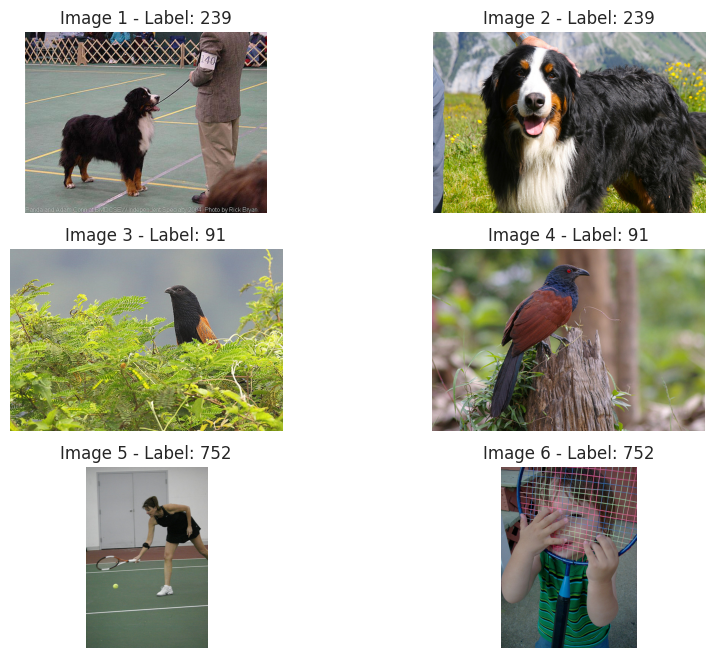

In [9]:
plt.figure(figsize=(10, 8))

plt.subplot(3, 2, 1)
plt.imshow(img_1)
plt.title(f'Image 1 - Label: {label_1}')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(img_2)
plt.title(f'Image 2 - Label: {label_2}')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(img_3)
plt.title(f'Image 3 - Label: {label_3}')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(img_4)
plt.title(f'Image 4 - Label: {label_4}')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(img_5)
plt.title(f'Image 5 - Label: {label_5}')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(img_6)
plt.title(f'Image 6 - Label: {label_6}')
plt.axis('off')


plt.show()


# Study embeddings of same classes and different classes.

In [23]:
x = torch.stack([transform(img) for img in imgs]).cuda()
with torch.no_grad():
    features = model.forward_features(x)
    norm_feat = features['x_norm'].cpu()
    prenorm_feat = features['x_prenorm'].cpu()

cls_tokens = norm_feat[:, 0]
cls_norm = cls_tokens.norm(dim=-1)
cross_correlation_matrix_dino = (cls_tokens @ cls_tokens.T) / cls_norm.outer(cls_norm)
cross_correlation_matrix_dino

tensor([[     1.00,      0.70,     -0.01,     -0.02,      0.05,      0.01],
        [     0.70,      1.00,     -0.02,     -0.03,      0.01,      0.01],
        [    -0.01,     -0.02,      1.00,      0.75,     -0.01,      0.00],
        [    -0.02,     -0.03,      0.75,      1.00,      0.01,     -0.02],
        [     0.05,      0.01,     -0.01,      0.01,      1.00,      0.48],
        [     0.01,      0.01,      0.00,     -0.02,      0.48,      1.00]])

In [24]:
# Finetuned CompViT
x = torch.stack([transform(img) for img in imgs]).cuda()
with torch.no_grad():
    features = compvit_ft.model.forward_features(x)
    norm_feat = features['x_norm'].cpu()
    prenorm_feat = features['x_prenorm'].cpu()

cls_tokens = norm_feat[:, 0]
cls_norm = cls_tokens.norm(dim=-1)
cross_correlation_matrix_compvit_ft = (cls_tokens @ cls_tokens.T) / cls_norm.outer(cls_norm)
cross_correlation_matrix_compvit_ft

tensor([[ 1.00,  0.31,  0.02,  0.02,  0.11,  0.06],
        [ 0.31,  1.00, -0.01, -0.01, -0.03, -0.01],
        [ 0.02, -0.01,  1.00,  0.71,  0.07, -0.00],
        [ 0.02, -0.01,  0.71,  1.00,  0.06,  0.01],
        [ 0.11, -0.03,  0.07,  0.06,  1.00,  0.21],
        [ 0.06, -0.01, -0.00,  0.01,  0.21,  1.00]])

In [35]:
F.mse_loss(cross_correlation_matrix_dino, cross_correlation_matrix_compvit_ft, reduction="sum")

tensor(0.50)

In [11]:
# Distilled CompViT
x = torch.stack([transform(img) for img in imgs]).cuda()
with torch.no_grad():
    features = compvit.forward_features(x)
    norm_feat = features['x_norm'].cpu()
    prenorm_feat = features['x_prenorm'].cpu()

cls_tokens = norm_feat[:, 0]
cls_norm = cls_tokens.norm(dim=-1)
cross_correlation_matrix_compvit = (cls_tokens @ cls_tokens.T) / cls_norm.outer(cls_norm)

In [12]:

print(compvit.forward_features(x)['x_prenorm'].shape)
compvit.set_compressed_tokens(64)
print(compvit.forward_features(x)['x_prenorm'].shape)

torch.Size([6, 33, 768])
torch.Size([6, 64, 768])


In [151]:
feature_dict = {f"img:{i + 1}": {} for i in range(NUM_PAIRS * 2)}

for i, img in enumerate(imgs):
    i = i + 1
    img = transform(img).unsqueeze(0).cuda()
    with torch.no_grad():
        features = model.forward_features(img)
        norm_feats = features['x_norm'].squeeze().cpu()
        prenorm_feats = features['x_prenorm'].squeeze().cpu()
    feature_dict[f"img:{i}"]["norm_feats"] = norm_feats
    feature_dict[f"img:{i}"]["prenorm_feats"] = prenorm_feats

In [8]:
import itertools


# Loop over the different keys using itertools.product
for key_1, key_2 in itertools.combinations(feature_dict, 2):
    feats_1 = feature_dict[key_1]
    feats_2 = feature_dict[key_2]

    norm_feats_1 = feats_1["norm_feats"]
    prenorm_feats_1 = feats_1["prenorm_feats"]
    
    norm_feats_2 = feats_2["norm_feats"]
    prenorm_feats_2 = feats_2["prenorm_feats"]

    cls_1 = norm_feats_1[0, :]
    cls_2 = norm_feats_2[0, :]
    patch2_1 = norm_feats_1[2:, :]
    patch2_2 = norm_feats_2[2:, :]

    # Compute the cosine similarity between cls tokens
    norm_sim = F.cosine_similarity(cls_1, cls_2, dim=-1)
    cls_1_norm = cls_1.norm()
    cls_2_norm = cls_2.norm()
    l2_distance = (cls_1 - cls_2).norm()

    # Comptue the cosine similarity between patch tokens
    patch2_sim = F.cosine_similarity(patch2_1, patch2_2, dim=-1)
    patch2_1_norm = patch2_1.norm()
    patch2_2_norm = patch2_2.norm()
    patch2_l2_distance = (patch2_1 - patch2_2).norm()

    message = f"""\
    ==========================
    {key_1} | {key_2} 
    {key_1} cls norm: {cls_1_norm: .2f}
    {key_2} cls norm: {cls_2_norm: .2f}
    cls similarity: {norm_sim.item(): .2f}
    cls l2: {l2_distance.item(): .2f}
    {key_1} patch2 norm: {patch2_1_norm: .2f}
    {key_2} patch2 norm: {patch2_2_norm: .2f}
    patch2 similarity: {patch2_sim.item(): .2f}
    patch2 l2: {patch2_l2_distance.item(): .2f}
    ==========================\
    """
    print(message)

    img:1 | img:2 
    img:1 cls norm:  48.48
    img:2 cls norm:  49.18
    cls similarity:  0.70
    cls l2:  37.62
    img:1 patch2 norm:  47.38
    img:2 patch2 norm:  46.83
    patch2 similarity:  0.18
    patch2 l2:  60.44
    img:1 | img:3 
    img:1 cls norm:  48.48
    img:3 cls norm:  48.37
    cls similarity: -0.01
    cls l2:  68.67
    img:1 patch2 norm:  47.38
    img:3 patch2 norm:  49.40
    patch2 similarity:  0.14
    patch2 l2:  63.30
    img:1 | img:4 
    img:1 cls norm:  48.48
    img:4 cls norm:  48.77
    cls similarity: -0.02
    cls l2:  69.62
    img:1 patch2 norm:  47.38
    img:4 patch2 norm:  47.84
    patch2 similarity:  0.13
    patch2 l2:  62.95
    img:1 | img:5 
    img:1 cls norm:  48.48
    img:5 cls norm:  47.98
    cls similarity:  0.05
    cls l2:  66.45
    img:1 patch2 norm:  47.38
    img:5 patch2 norm:  50.52
    patch2 similarity:  0.36
    patch2 l2:  55.33
    img:1 | img:6 
    img:1 cls norm:  48.48
    img:6 cls norm:  46.88
    cls sim